# LightGBM模型

## LightGBM模型核心思想

**LightGBM（Light Gradient Boosting Machine）**模型是一种基于梯度提升框架的Boosting模型。LightGBM是基于XGBOOST模型设计的改进模型，相比于XGBOOST模型，LightGBM模型做了如下改进：
- **基于直方图的决策树学习**：
    - 在XGBOOST模型中，决策树的分裂是通过枚举所有特征值来寻找最佳分裂点，这对于大规模数据来说非常慢
    - 在 LightGBM 中，特征值被离散化为直方图桶，然后在直方图桶上寻找最佳分裂点。这样减少了特征值的处理次数，从而加快了训练速度，并降低了内存使用。
- **叶子优先的生长策略**：
    - XGBoost 使用层级优先（Level-wise）的树生长策略，即每次从当前树的每一层选择最佳的分裂点。这种策略生成的树通常较为平衡，树的深度较为均匀，但可能拟合度不如叶子优先
    - LightGBM 使用叶子优先（Leaf-wise）的生长策略，即每次选择当前树中残差最大的叶子进行分裂。这种策略能够更好地减少残差，因此通常会生成更深的树，从而能更好地拟合数据
    - 叶子优先策略相较于层级优先，在 减少残差上更有效，通常能够提高模型的精度，但也有可能导致过拟合。为此，LightGBM 提供了调节 最大深度（max_depth） 和 叶子节点最小样本数（min_data_in_leaf） 等超参数，以控制过拟合
- **更高效的类别特征处理方法**：
    - XGBoost 在处理类别特征时，需要先进行 one-hot 编码 或 整数编码。如果类别特征有大量的类别，one-hot 编码会导致特征维度的显著增加，从而增加计算复杂度和内存消耗
    - LightGBM 可以 直接处理类别特征，无需进行 one-hot 编码。它通过优化算法自动处理类别特征，这对于处理类别维度非常高的特征（如数百万个类别）非常有用，能够显著减少内存使用和提高训练效率
- **更高效的分布式训练**：
    - XGBoost支持数据并行和特征并行的分布式训练，能够在多台机器上分配任务进行计算，从而加速训练过程
    - LightGBM 在分布式训练上进行了进一步优化，也支持数据并行和特征并行，但是处理效率更高

## LightGBM模型主要步骤

LightGBM模型的主要步骤概括如下：

1. **初始化**：
    - 首先，LightGBM模型会用一个简单的模型（如常数模型）对所有样本做出初始预测。
2. **迭代优化**：
    - **计算梯度和二阶梯度**：基于当前模型的预测结果，计算每个样本的梯度（误差）和二阶梯度（误差变化率）。
    - **拟合决策树**：基于梯度和二阶梯度，将其作为目标变量来训练一棵决策树。LightGBM 使用 叶子优先（Leaf-wise） 的树生长策略，从残差最大的位置开始分裂，使得每棵树都能更好地拟合训练数据。
    - **更新预测**：将新训练的决策树加入到模型中，更新每个样本的预测值为原预测值加上新决策树的输出。
    - **重复上述过程**，直到达到预设的迭代次数或满足停止条件。
3. **构建最终模型**：
    - 所有决策树的加权预测结果组合起来，形成最终的强学习器。

## LightGBM模型优缺点

### LightGBM模型的优点

- **直方图算法效率高**：在 LightGBM 中，特征值被离散化为直方图桶，然后在直方图桶上寻找最佳分裂点。这样减少了特征值的处理次数，从而加快了训练速度，并降低了内存使用
- **叶子优先生长策略（Leaf-wise）**：LightGBM 使用叶子优先的策略，相比层级优先生长（Level-wise），它能更快地收敛并获得更低的训练误差，尤其在数据复杂度较高时表现出色
- **内置类别特征支持**：与其他梯度提升算法（如 XGBoost）不同，LightGBM 能够直接处理类别特征，无需进行 one-hot 编码或其他复杂预处理。这减少了特征空间的维度，避免了由于特征扩展造成的计算复杂度和内存消耗

### LightGBM模型的缺点

- **过拟合风险高**：相比于XGBOOST模型的层级优先生长策略，LightGBM模型所使用的叶子优先生长策略更容易生成深树，这会导致模型更容易捕获到数据中的噪声，导致过拟合。
- **对超参数调节敏感**：LightGBM模型的性能很大程度上依赖于 超参数调节。选择合适的学习率、树的深度、正则化参数等非常关键。如果调参不当，模型可能会过拟合或欠拟合。因此最好使用交叉验证或网格搜索等方法来帮助LightGBM模型选择最优超参数

# LightGBM模型案例（二分类）

lightgbm版本为4.6.0

确保版本一致，否则可能会出现错误

## lightgbm模型参数

### params参数

- **objective**: 任务类型
    - 二分类: 'binary'
    - 多分类: 'multiclass'
    - 回归: 'regression'
    - 排序: 'lambdarank'
- **num_class**: 多分类类别数（仅多分类任务使用）。
- **metric**：评估指标
    - 二分类: 'auc'、'binary_logloss'
    - 多分类: 'multi_logloss'
    - 回归: 'rmse'（均方根误差RMSE）、'l1'（平均绝对误差MAE）、'l2'（均方误差MSE）、'mape'（平均绝对百分比误差MAPE）
- **max_depth**: 决策树的最大深度。控制模型复杂度，值越大模型越容易过拟合。
- **num_leaves**: 叶子节点数
- **min_data_in_leaf**: 叶子最小样本数。防止过拟合小样本。
- **learning_rate**: 学习率，控制每棵树对最终结果的影响，值越小训练越慢但更稳定。通常设置在 0.01 到 0.3 之间。  
- **feature_fraction**: 特征采样比例。
- **bagging_fraction**: 数据采样比例。
- **lambda_l1**: L1正则化系数。
- **lambda_l2**: L2正则化系数。
- **verbosity**: 控制训练过程输出。
    - 0：输出全部信息
    - 1：输出警告信息
    - 2：输出详细信息
    - 3：仅输出致命错误  
- **seed**: 随机数种子。

### lgb.train参数

- **params**: 2.1.1节中params参数，dict格式
- **train_set**: 训练数据，lightgbm.Dataset 格式，包含特征和标签。
- **num_boost_round**: 训练轮数，也即树的棵树。
- **valid_sets**: 验证集列表，验证集列表，用于监控模型效果。
- **valid_names**: 给验证集命名，和 valid_sets 一一对应。
- **feval**: 自定义评估函数，返回 (名称, 分数)，如 F1、精确率、召回率等。
- **init_model**: 是否从已有模型继续训练。
    - 已有模型路径
    - 已训练的 Booster 对象
    - None 表示从头开始
- **callbacks**: 回调函数:
    - lgb.early_stopping(stopping_rounds=xx): 设置早停步数
    - lgb.log_evaluation(period=xx): 每隔 xx 次打印一次日志
    - lgb.record_evaluation(eval_result_dict): 将每轮评估结果保存到字典中

## 泰坦尼克数据集

**titanic 数据集**包含了 891 条乘客记录，每条记录描述了乘客的个人信息及其在 Titanic 号上的生存情况
- survived：生存情况（0 = 未生还, 1 = 生还）
- pclass：乘客舱等级（1 = 一等舱, 2 = 二等舱, 3 = 三等舱）
- sex：乘客性别（male = 男性, female = 女性）
- age：乘客年龄（float，部分缺失值）
- sibsp：乘客在船上的兄弟姐妹或配偶数量（整数）
- parch：乘客在船上的父母或子女数量（整数）
- fare：乘客支付的票价（float）
- embarked：乘客登船港口（C = 瑟堡, Q = 皇后镇, S = 南安普敦）
- class：舱等级（文本版本的 pclass，First = 头等舱, Second = 二等舱, Third = 三等舱）
- who：乘客身份（man = 成年男性, woman = 成年女性, child = 儿童）
- adult_male：是否为成年男性（True = 是, False = 否）
- deck：乘客所在的甲板（A, B, C, D, E, F, G，部分缺失值较多）
- embark_town：乘客登船的城市（Cherbourg = 瑟堡, Queenstown = 皇后镇, Southampton = 南安普敦）
- alone：是否独自旅行（True = 独自旅行，False = 有亲属同行，对应 sibsp + parch == 0）

In [5]:
# 导入必要的库
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                           classification_report, roc_curve, auc)
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# 加载seaborn内置的泰坦尼克数据集
df = sns.load_dataset('titanic')

# 填充 'age' 列的缺失值：使用该列的中位数填充缺失值
df['age'].fillna(df['age'].median(), inplace=True)
# 填充 'embarked' 列的缺失值：使用该列的众数填充缺失值
df['embarked'].fillna(df['embarked'].mode()[0], inplace=True)
# 将 'sex' 列转化为数值：'male' 映射为 1，'female' 映射为 0
df['sex'] = df['sex'].map({'male': 1, 'female': 0})
# 将 'embarked' 列转化为数值：'C' 映射为 0，'Q' 映射为 1，'S' 映射为 2
df['embarked'] = df['embarked'].map({'C': 0, 'Q': 1, 'S': 2})

df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,1,22.0,1,0,7.2500,2,Third,man,True,NaN,Southampton,no,False
1,1,1,0,38.0,1,0,71.2833,0,First,woman,False,C,Cherbourg,yes,False
2,1,3,0,26.0,0,0,7.9250,2,Third,woman,False,NaN,Southampton,yes,True
3,1,1,0,35.0,1,0,53.1000,2,First,woman,False,C,Southampton,yes,False
4,0,3,1,35.0,0,0,8.0500,2,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,2,Second,man,True,NaN,Southampton,no,True
887,1,1,0,19.0,0,0,30.0000,2,First,woman,False,B,Southampton,yes,True
888,0,3,0,28.0,1,2,23.4500,2,Third,woman,False,NaN,Southampton,no,False
889,1,1,1,26.0,0,0,30.0000,0,First,man,True,C,Cherbourg,yes,True


## 代码实现

lightgbm版本必须是4.6.0，否则可能报错

Training until validation scores don't improve for 50 rounds
[10]	train's auc: 0.892442	train's binary_logloss: 0.562138	valid's auc: 0.896268	valid's binary_logloss: 0.577249
[20]	train's auc: 0.899506	train's binary_logloss: 0.501533	valid's auc: 0.89749	valid's binary_logloss: 0.517511
[30]	train's auc: 0.903187	train's binary_logloss: 0.460405	valid's auc: 0.897812	valid's binary_logloss: 0.480388
[40]	train's auc: 0.904792	train's binary_logloss: 0.431372	valid's auc: 0.900772	valid's binary_logloss: 0.455664
[50]	train's auc: 0.907145	train's binary_logloss: 0.41052	valid's auc: 0.901287	valid's binary_logloss: 0.439505
[60]	train's auc: 0.912347	train's binary_logloss: 0.392393	valid's auc: 0.901158	valid's binary_logloss: 0.426284
[70]	train's auc: 0.917167	train's binary_logloss: 0.378089	valid's auc: 0.901158	valid's binary_logloss: 0.4187
[80]	train's auc: 0.920982	train's binary_logloss: 0.366663	valid's auc: 0.900644	valid's binary_logloss: 0.413547
[90]	train's auc: 0.924

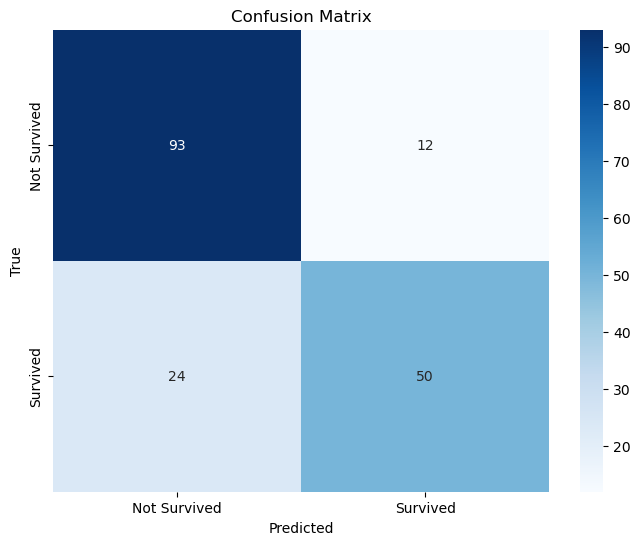

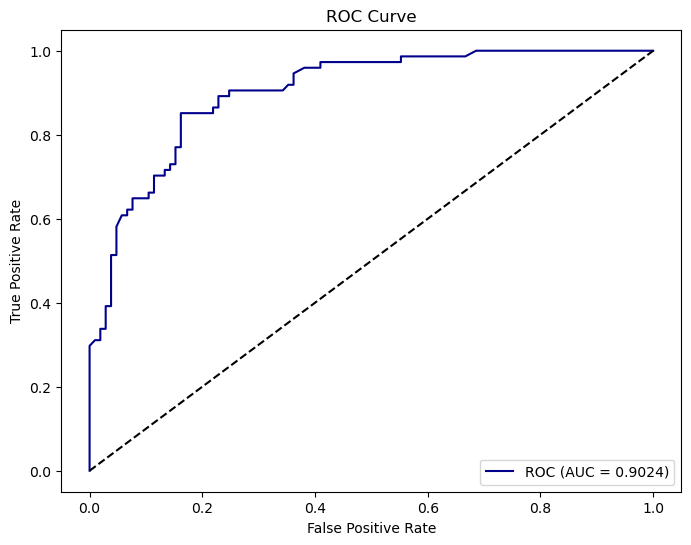

In [9]:
# ============ 1. 导入库 ============
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# ============ 2. 数据准备 ============
# 假设 df 是已经加载的 Pandas DataFrame（例如泰坦尼克数据集）
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']  # 选择的特征列
X = df[features].dropna()  # 提取特征并删除缺失值
y = df.loc[X.index, 'survived']  # 提取对应的目标列（幸存与否）

# 划分训练集和验证集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,    # 验证集占比20%
    random_state=42   # 随机种子保证可复现性
)

# ============ 3. 创建LightGBM数据集 ============
dtrain = lgb.Dataset(
    X_train, 
    label=y_train,
)
dtest = lgb.Dataset(
    X_test, 
    label=y_test,
)

# ============ 4. 配置模型参数 ============
params = {
    # 任务类型和评估指标
    'objective': 'binary',               # 二分类任务
    'metric': {'binary_logloss', 'auc'}, # 同时监控对数损失和AUC
    
    # 树结构控制
    'num_leaves': 60,       # 叶子节点数（控制模型复杂度）
    'max_depth': -1,        # -1表示不限制深度（通常用num_leaves控制）
    'min_data_in_leaf': 30, # 叶子节点最小样本数（防过拟合）
    
    # 训练过程控制
    'learning_rate': 0.03,  # 学习率（步长）
    'feature_fraction': 0.9, # 每轮随机选择90%特征
    'bagging_fraction': 0.8, # 每轮随机选择80%数据
    
    # 正则化
    'lambda_l1': 0.1,       # L1正则化系数
    'lambda_l2': 0.001,     # L2正则化系数
    
    # 其他
    'verbosity': -1,        # 静默模式（不输出训练日志）
    'seed': 2019    # 随机种子
}

# ============ 5. 训练模型 ============
lgb_clf = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=1000,    # 最大迭代轮数
    valid_sets=[dtrain, dtest],  # 监控训练集和验证集表现
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),  # 早停（50轮无提升停止）
        lgb.log_evaluation(period=10)            # 每10轮打印一次日志
    ]
)

# ============ 6. 模型预测 ============
# 预测概率值（0~1之间的浮点数）
y_probs = lgb_clf.predict(X_test)  # 使用最优迭代轮数

# 将概率转为类别（阈值0.5）
y_pred = (y_probs > 0.5).astype(int)

# ============ 7. 评估指标 ============
# 打印分类报告（精确率、召回率、F1等）
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# ============ 8. 可视化 ============
# (1) 混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix, 
    annot=True,           # 显示数值
    fmt="d",             # 整数格式
    cmap="Blues",        # 颜色映射
    xticklabels=["Not Survived", "Survived"],
    yticklabels=["Not Survived", "Survived"]
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# (2) ROC曲线
fpr, tpr, _ = roc_curve(y_test, y_probs)  # 计算ROC曲线坐标
roc_auc = auc(fpr, tpr)                  # 计算AUC值

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkblue', label=f'ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # 绘制对角线（随机猜测）
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# LightGBM可视化

## lgb_plot.plot_tree

**lgb_plot.plot_tree**: 生成直观的LightGBM树形结构图
- `booster`: 训练好的LightGBM模型
- `tree_index`: 要绘制第几棵树（从 0 开始），可用循环遍历多棵树
- `figsize`: 图的宽高，单位为英寸
- `dpi`: 分辨率（每英寸点数）
- `show_info`: 要在节点中显示的附加信息，可选值如下：
    - "split_gain"：增益
    - "internal_value"：节点的值
    - "internal_count"：内部节点样本数
    - "leaf_count"：叶子节点样本数
- `precision`: 小数显示的精度（默认保留3位）
- `orientation`: 决定图的布局方向：
    - `horizontal`：从上到下（默认）
    - `vertical`：从左到右（推荐更清晰）

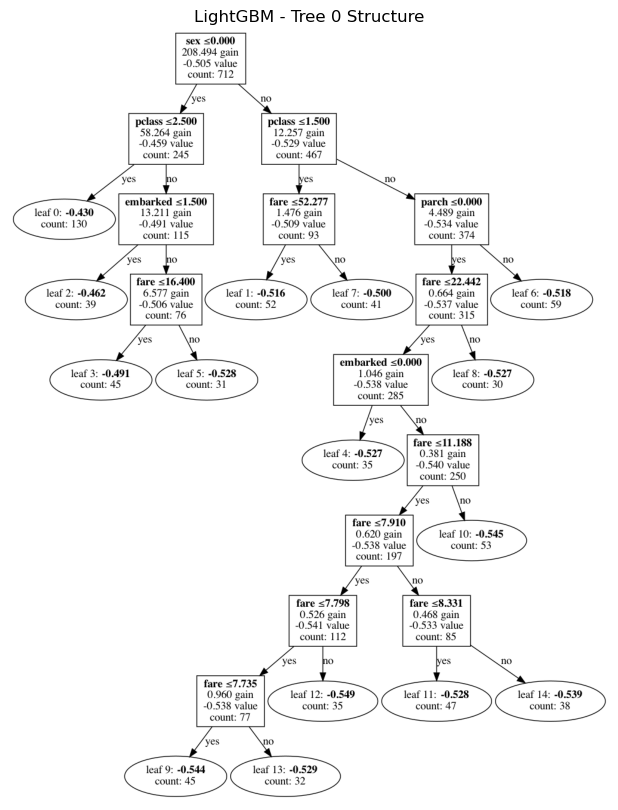

In [10]:
import graphviz
import lightgbm.plotting as lgb_plot
from IPython.display import display

# 可视化第0棵树（可以改成其他编号）
lgb_plot.plot_tree(
    booster=lgb_clf,
    tree_index=0,
    figsize=(20, 10),
    show_info=['split_gain', 'internal_value', 'internal_count', 'leaf_count'],
    orientation='vertical'
)
plt.title("LightGBM - Tree 0 Structure")
plt.show()

# 特征重要度

在 LightGBM 中，**特征重要性（Feature Importance）** 是衡量每个特征在模型构建中贡献程度的重要指标。由于 LightGBM 是基于 **梯度提升框架** 的 **基于叶子的决策树模型（Leaf-wise Tree）**，它通过最小化损失函数迭代构建树，因此可以记录每个特征在模型训练过程中的“使用次数”、“信息增益”等指标，来衡量其重要性。

## LightGBM 中的特征重要性计算方式

LightGBM 提供 两种主流的特征重要性指标：

| 指标类型    | 含义说明                        |
| ------- | --------------------------- |
| `split` | 特征被用作节点划分的次数（频率）            |
| `gain`  | 使用该特征划分节点所带来的损失函数下降总量（信息增益） |


## split（分裂频次 / 使用次数）

- **定义**：某特征在所有树中被用作分裂节点的次数总和。 
    - 如果一个特征频繁出现在树的节点中，说明它对树的划分有广泛的贡献。 
    - 但它不考虑每次分裂的“质量”（是否带来显著增益）。 
- **计算公式**：
    $$\text{Importance}_j^{(\text{split})} = \sum_{m=1}^{M} \sum_{t \in T_m} \mathbb{1}(j = \text{feature}(t)) $$
其中：
    - $M$：总树数（boosting round） 
    - $T_m$：第$m$棵树的所有非叶节点集合 
    - $\mathbb{1}(j = \text{feature}(t))$：如果节点$t$使用了特征$j$进行划分，则为 1，否则为 0 
- **优点**：
    - 简单直观，易于解释。 
- **缺点**：
    - 可能会高估“常被选中但增益较低”的特征。 
    - 不考虑特征实际提升模型性能的程度。 
- **适合场景**：
    - 初步筛选特征（例如是否经常被使用）。 

## gain（平均信息增益，推荐）

- **定义**：某特征被用来分裂时，对模型损失函数（如 logloss, mse）带来的平均下降量（即平均提升）。 
    - 更关注“质量”而不是“次数”，代表该特征“每次使用是否有价值”。 
    - 通常是更可靠的特征重要性衡量标准。 
- **计算公式**：
$$\text{Importance}_j^{(\text{gain})} = \sum_{m=1}^{M} \sum_{t \in T_m} \Delta \mathcal{L}_t \cdot \mathbb{1}(j = \text{feature}(t)) $$
其中：
    - $M$：总树数（boosting round） 
    - $T_m$：第$m$棵树的所有非叶节点集合 
    - $\Delta \mathcal{L}_t$：节点$t$分裂带来的 损失函数下降（loss reduction）
    - $\mathbb{1}(j = \text{feature}(t))$：如果节点$t$使用了特征$j$进行划分，则为 1，否则为 0 
- **优点**：
    - 与模型性能直接相关。 
    - 强调了特征的“实际贡献”。 
- **缺点**：
    - 在样本不平衡或分裂稳定性差时可能波动较大。 
- **适合场景**：
    - 高质量特征排序、模型解释、业务特征分析。 

## 特征重要度代码实现与可视化

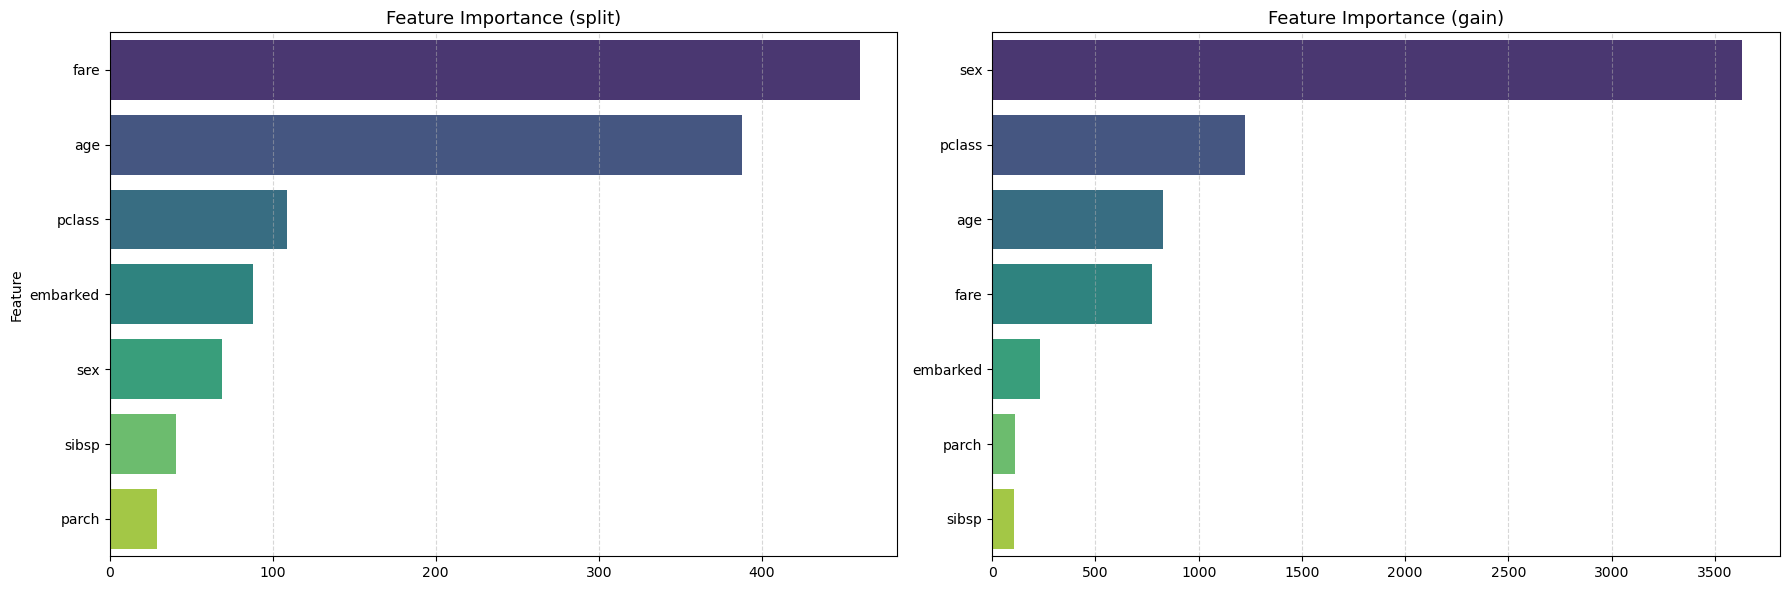

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 设置特征重要性类型：分裂次数、增益
importance_types = ['split', 'gain']
importance_data = {}

# 获取特征名称列表（对应训练时的列名）
feature_names = lgb_clf.feature_name()

# 遍历每种特征重要性类型
for imp_type in importance_types:
    # 获取指定类型的重要性值（返回的是按特征顺序的数组）
    importances = lgb_clf.feature_importance(importance_type=imp_type)

    # 构建 DataFrame：列为“特征名”和对应的重要性数值
    imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)  # 按重要性降序排列

    # 存储到字典中备用（可同时画多个子图）
    importance_data[imp_type] = imp_df

# 创建一个横排的 1 行 2 列图像区域
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 遍历 importance_types 及其对应子图坐标
for i, imp_type in enumerate(importance_types):
    # 使用 seaborn 绘制水平条形图（左侧为特征名）
    sns.barplot(
        ax=axes[i],                                # 对应子图坐标
        data=importance_data[imp_type],            # 对应数据
        x='Importance',                            # 横坐标：重要性数值
        y='Feature',                               # 纵坐标：特征名称
        palette='viridis'                          # 使用 viridis 调色板
    )
    # 设置子图标题
    axes[i].set_title(f'Feature Importance ({imp_type})', fontsize=13)

    # 隐藏 x 轴标签（横坐标本身已表达含义）
    axes[i].set_xlabel('')
    
    # 除第一个子图外都隐藏 y 轴标签（节省空间）
    axes[i].set_ylabel('Feature' if i == 0 else '')

    # 添加网格线（横向，增强可读性）
    axes[i].grid(True, axis='x', linestyle='--', alpha=0.5)

# 自动调整子图间距，防止重叠
plt.tight_layout()

# 展示最终图像
plt.show()